In [3]:
!pip install pyro-ppl

     |████████████████████████████████| 501kB 2.8MB/s 


In [1]:
# import pytorch and pyro; set random generator seed
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from tqdm.notebook import trange

pyro.set_rng_seed(101)

# to clear all variables stored by Pyro
pyro.clear_param_store()

# enable validation for useful warnings and errors
pyro.enable_validation(True)


----
Homework
-------




1. Prepare a Pyro model function, which will express the number of buses arriving and the bus stop in an hour. Assume [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) of the number of arrivals in per hour:

   $$N \sim Pois\left(\lambda\right)$$

   where $\lambda$ is set using a function:
   
   $$\lambda = \left\{\begin{array}{c} 2 + 2 * \sin\left(\frac{\pi}{16}\left(t - 8\right)\right),\; t \in \left[8, 24\right]  \\ 1,\; t \notin \left[8, 24\right] \end{array}\right.$$
   
   Where $t$ is hour of the day. Use the function from the cell below.
   
   For each hour print 3 sampels of bus arrivals. 


In [28]:
from math import sin, pi
  
def count_lambda(t):
  return 2 + 2 * sin(pi/16 * (t-8)) if t >= 8 and t <=24 else 1

def bus_arrival(hour):
    lmbda = count_lambda(hour)
    return pyro.sample('buses', dist.Poisson(lmbda))
    

for hour in range(1,25):
    print(hour, [bus_arrival(hour).item() for _ in range(3)])

1 [0.0, 0.0, 0.0]
2 [1.0, 2.0, 1.0]
3 [0.0, 2.0, 1.0]
4 [1.0, 0.0, 1.0]
5 [1.0, 0.0, 2.0]
6 [0.0, 1.0, 0.0]
7 [2.0, 1.0, 1.0]
8 [1.0, 2.0, 3.0]
9 [5.0, 2.0, 2.0]
10 [5.0, 3.0, 4.0]
11 [4.0, 5.0, 3.0]
12 [6.0, 4.0, 4.0]
13 [6.0, 5.0, 6.0]
14 [4.0, 6.0, 3.0]
15 [2.0, 1.0, 9.0]
16 [3.0, 1.0, 3.0]
17 [4.0, 4.0, 2.0]
18 [4.0, 3.0, 2.0]
19 [8.0, 3.0, 3.0]
20 [5.0, 4.0, 3.0]
21 [4.0, 1.0, 1.0]
22 [4.0, 3.0, 2.0]
23 [2.0, 2.0, 1.0]
24 [0.0, 2.0, 2.0]


2. Prepare a simpler guide, that will try to approximate `bus_arrival()` using only Poisson distribution (with $\lambda$ as a param).

$$N_{approx} \sim Pois\left(\lambda\right)$$

   Train the model for hour 14.00 (`hour = 14.00`) and display how both params vary.


In [0]:
def bus_arrival_guide(t):
    rate = pyro.param('rate', torch.tensor(1.))
    pyro.sample('buses', dist.Poisson(rate))


rate = 3.846804618835449


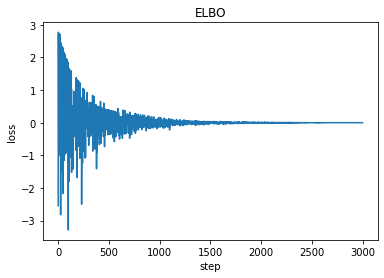

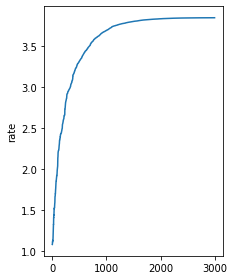

real rate =  3.8477590650225735


In [33]:
lr = 1e-2
n_steps = 3000
hour = 14.0

pyro.clear_param_store()
svi = pyro.infer.SVI(model=bus_arrival,
                     guide=bus_arrival_guide,
                     optim=pyro.optim.SGD({"lr": lr}),
                     loss=pyro.infer.Trace_ELBO())


losses, rates = [], []

for t in trange(n_steps):
    losses.append(svi.step(hour))
    rates.append(pyro.param("rate").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print(f"rate = {pyro.param('rate').item()}")
plt.show()

plt.subplot(1,2,1)
plt.plot(rates)
plt.ylabel('rate')
plt.tight_layout()
plt.show()
print('real rate = ',count_lambda(hour))
